In [20]:
import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from pycocotools.coco import COCO
import copy
import os
import cv2
from PIL import Image, ImageDraw, ImageFont
import random

In [21]:
def select_data_by_index(data, idx):
    new_data = copy.deepcopy(data)
    images = [image for image in data['images'] if image['id'] in idx]
    anns = [ann for ann in data['annotations'] if ann['image_id'] in idx]

    new_data['images'] = images
    new_data['annotations'] = anns
    return new_data

def save_json(path, data):
    with open(path, 'w') as f:
        json.dump(data, f, indent=4)

def load_json(path):
    with open(path) as f:
        return json.load(f)

In [22]:
json_path = '/data/ephemeral/home/data/dataset/train.json'
result_dir_path = 'result'

random_state = 7777
n_splits = [5, 10]
 
os.makedirs(result_dir_path, exist_ok=True)
data = load_json(json_path)

var = [(ann['image_id'], ann['category_id']) for ann in data['annotations']]
X = np.ones((len(data['annotations']), 1))
y = np.array([v[1] for v in var]) # category_id
groups = np.array([v[0] for v in var]) # image_id

for n_split in n_splits:
    cv = StratifiedGroupKFold(n_splits=n_split, shuffle=True, random_state=random_state)

    for i, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
        train_data = select_data_by_index(data, train_idx)
        valid_data = select_data_by_index(data, valid_idx)

        train_path = os.path.join(result_dir_path, f'train_{i}_{n_split}.json')
        valid_path = os.path.join(result_dir_path, f'valid_{i}_{n_split}.json')

        save_json(train_path, train_data)
        save_json(valid_path, valid_data)

In [23]:
# Test train valid overlap
# train/valid image id overlap이 0이면 정상

for n_split in n_splits:
    for i in range(n_split):
        train_path = os.path.join(result_dir_path, f'train_{i}_{n_split}.json')
        valid_path = os.path.join(result_dir_path, f'valid_{i}_{n_split}.json')

        train_data = load_json(train_path)
        valid_data = load_json(valid_path)

        train_image_id = [image['id'] for image in train_data['images']]
        valid_image_id = [image['id'] for image in valid_data['images']]

        count_overlap = sum([1 for id in train_image_id if id in valid_image_id])
        print(f"{i}/{n_split} - train/valid image id overlap: {count_overlap}")

0/5 - train/valid image id overlap: 0
1/5 - train/valid image id overlap: 0
2/5 - train/valid image id overlap: 0
3/5 - train/valid image id overlap: 0
4/5 - train/valid image id overlap: 0
0/10 - train/valid image id overlap: 0
1/10 - train/valid image id overlap: 0
2/10 - train/valid image id overlap: 0
3/10 - train/valid image id overlap: 0
4/10 - train/valid image id overlap: 0
5/10 - train/valid image id overlap: 0
6/10 - train/valid image id overlap: 0
7/10 - train/valid image id overlap: 0
8/10 - train/valid image id overlap: 0
9/10 - train/valid image id overlap: 0


In [24]:
# Visualize the result 
json_path = 'result/train_0_5.json'
data_dir_path = '/data/ephemeral/home/data/dataset'
font_path = '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf'

classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
id2label = {id: label for id, label in enumerate(classes)}
label2id = {label: id for id, label in id2label.items()}

coco = COCO(json_path)
image_ids = coco.getImgIds()

font = ImageFont.truetype(font_path, size=50)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


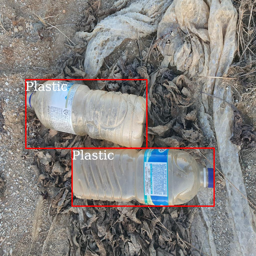

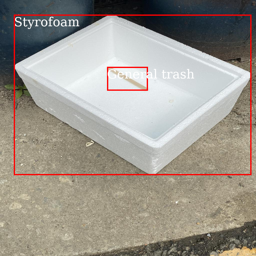

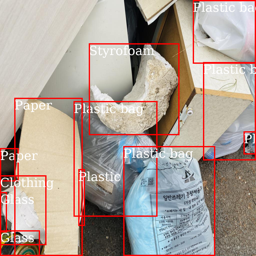

In [25]:
image_ids_sample = random.sample(image_ids, 3)

for image_id in image_ids_sample:
    image_info = coco.loadImgs(image_id)[0]
    anns_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(anns_ids)

    image = cv2.imread(os.path.join(data_dir_path, image_info['file_name']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

    pil_image = Image.fromarray(np.array(image).astype(np.uint8))
    draw = ImageDraw.Draw(pil_image)

    for ann in anns:
        box = ann["bbox"]
        class_idx = ann["category_id"]
        x, y, w, h = tuple(box)
        # Check if coordinates are normalized or not
        if max(box) > 1.0:
            # Coordinates are un-normalized, no need to re-scale them
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            # Coordinates are normalized, re-scale them
            x1 = int(x * w)
            y1 = int(y * h)
            x2 = int((x + w) * w)
            y2 = int((y + h) * h)
        draw.rectangle((x, y, x + w, y + h), outline="red", width=5)
        draw.text((x, y), id2label[class_idx], fill="white", font=font)

    pil_image = pil_image.resize((256, 256))
    pil_image.show()